In [3]:
from __future__ import division
import sys
sys.path.append('../src')
import params
import numpy as np
import os
from tqdm import tqdm

model_folder = '../models/'

model_filename = '1472001110_stacked/1472001110_stacked_epoch224.npz'
model_path = os.path.join(model_folder, model_filename)

params.params = params.Params(['../config/default.ini'] + 
                              ['../config/stacked.ini', '../config/titania_stacked.ini'])
from params import params as P
import theano
import theano.tensor as T
import lasagne
import resnet

import patch_sampling
from cparallel import ContinuousParallelBatchIterator

input_var = T.tensor4('inputs')

Loaded configurations from (in order) ['../src/../config/default.ini', '../src/../config/notebook.ini']
Loaded configurations from (in order) ['../config/default.ini', '../config/stacked.ini', '../config/titania_stacked.ini']
Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 2: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


OpenCV 2 NOT AVAILABLE, using skimage/scipy.ndimage instead


In [4]:
train_generator, validation_generator, train_sampler, validation_sampler = (
    
    patch_sampling.prepare_custom_sampler(mini_subset=False, override_cache_size=3, return_samplers=True)

)

Loading train samplers
Loading validation samplers
Loading samplers took 43.0840771198 seconds.


In [5]:
# DEFINE AND LOAD NETWORK

input_var = T.tensor4('inputs')
target_var = T.ivector('targets')

net = resnet.ResNet_FullPre_Wide(input_var, 4, 2)
all_layers = lasagne.layers.get_all_layers(net)
net = all_layers[-3]
net = resnet.ResNet_Stacked_Old(net)

with np.load(model_path) as f:
    param_values = [f['arr_%d' % i] for i in range(len(f.files))]

lasagne.layers.set_all_param_values(net, param_values)

In [6]:
predict_fn = resnet.define_predict(net, input_var, target_var)

In [7]:
batch_size = 50
X = [batch_size]*1000

batch_gen = ContinuousParallelBatchIterator(validation_generator, 
                                            ordered=False, batch_size=1, multiprocess=False, n_producers=3)
batch_gen.append(X)

In [8]:
all_inputs = []
all_targets = []
all_filenames = []

all_loss = []
all_pred = []
all_binary_pred = []

In [9]:
for i, batch in enumerate(tqdm(batch_gen(200))):
    inputs, targets, filenames = batch
    
    loss, acc, pred_binary, pred = predict_fn(inputs, targets)
    
    for x in range(len(inputs)):
        
        filename = filenames[x]
        target = targets[x]
        p = pred[x]
        p_binary = pred_binary[x]
        l = loss[x]
        
        #all_inputs.append(inputs[x].astype(np.float16))
        all_targets.append(target)
        all_filenames.append(filename)
        all_pred.append(p)
        all_binary_pred.append(p_binary)
        all_loss.append(l)
            
    del inputs

100%|██████████| 200/200 [51:54<00:00, 14.82s/it]


In [22]:
file_loss = {}
file_count = {}
file_target = {}

for filename, target, prediction, prediction_binary, loss in zip(all_filenames, all_targets, all_pred, all_binary_pred, all_loss):
    
    if filename not in file_loss:
        file_loss[filename] = 0
        file_count[filename] = 0
        
    file_loss[filename] += loss
    file_count[filename] += 1
    file_target[filename] = target


In [23]:
# Average loss per file
file_avg_loss = {f:file_loss[f]/file_count[f] for f in np.unique(filenames)}
import operator
file_loss_tups = file_avg_loss.iteritems()
# Sort by loss
file_loss_tups = list(reversed(sorted(file_loss_tups, key=operator.itemgetter(1))))


In [24]:
import util
misclassified = np.array(all_binary_pred) != np.array(all_targets)
print "Amount of wrong labels", np.sum(misclassified), "out of", len(all_targets)
#wrong_images = util.unzero_center(wrong_images, P.MEAN_PIXEL)
#wrong_images = wrong_images.transpose(0,2,3,1)

Amount of wrong labels 1146 out of 10000


In [25]:
sampler_of_filename = {}

all_samplers = []
for x in validation_sampler.per_label_sampler_list.values():
    print len(x)
    all_samplers += x

    
i = 0
for sampler in all_samplers:
    
    i += 1
    #print sampler.filename
    sampler_of_filename[sampler.filename] = sampler

795
151
432


In [26]:
wrong_images = []

for (f, l) in tqdm(file_loss_tups[:18]):
    im = sampler_of_filename[f].sample_full()
    im = util.normalize_image(im)
    wrong_images.append(im)

100%|██████████| 18/18 [00:29<00:00,  2.53s/it]


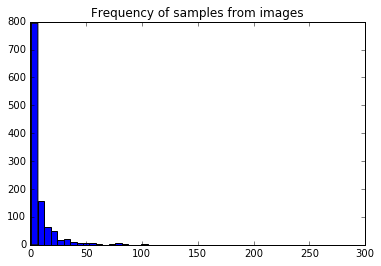

/media/diskA/guido/Level1_LargePatch_Aug17/Original/Validation/Label2/T14-25889-I-1V2_cropped_8.jpeg
290


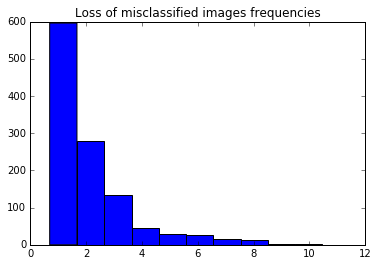

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(file_count.values(), 50)
plt.title("Frequency of samples from images")
plt.show()

print all_filenames[np.argmax(file_count.values())]
print np.max(file_count.values())

plt.hist(np.array(all_loss)[misclassified], 10)
plt.title("Loss of misclassified images frequencies")
plt.show()




## Predictions that are most wrong
(Number in the title of the images is the loss of that prediction)

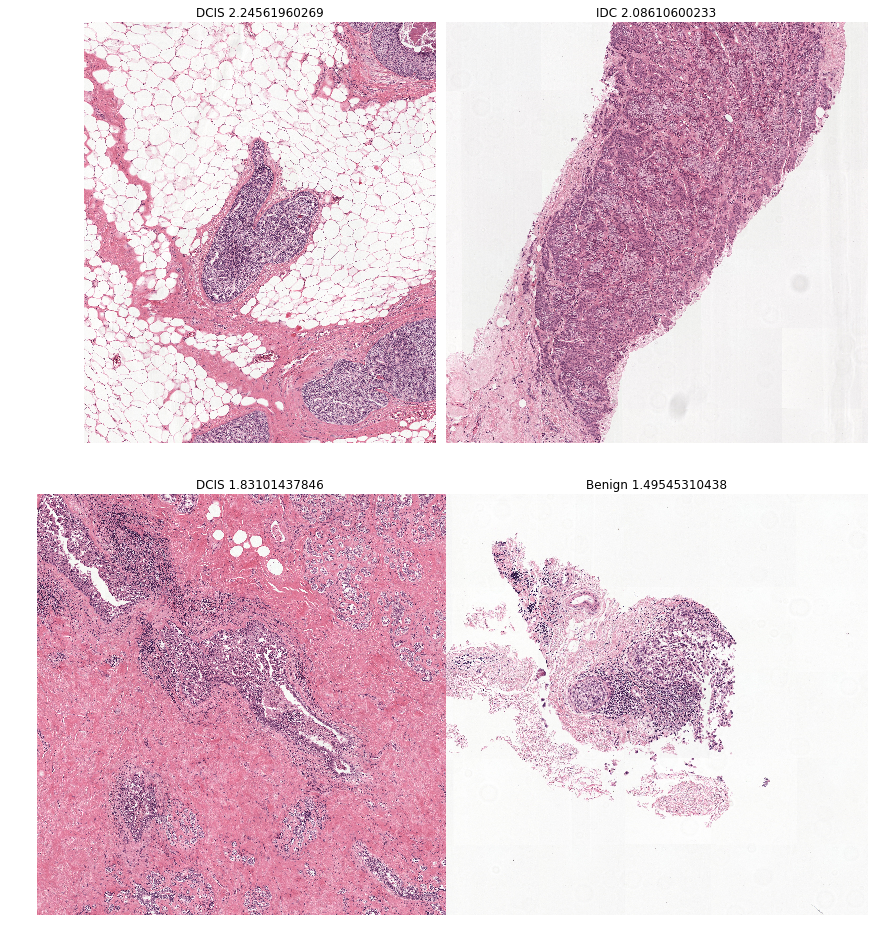

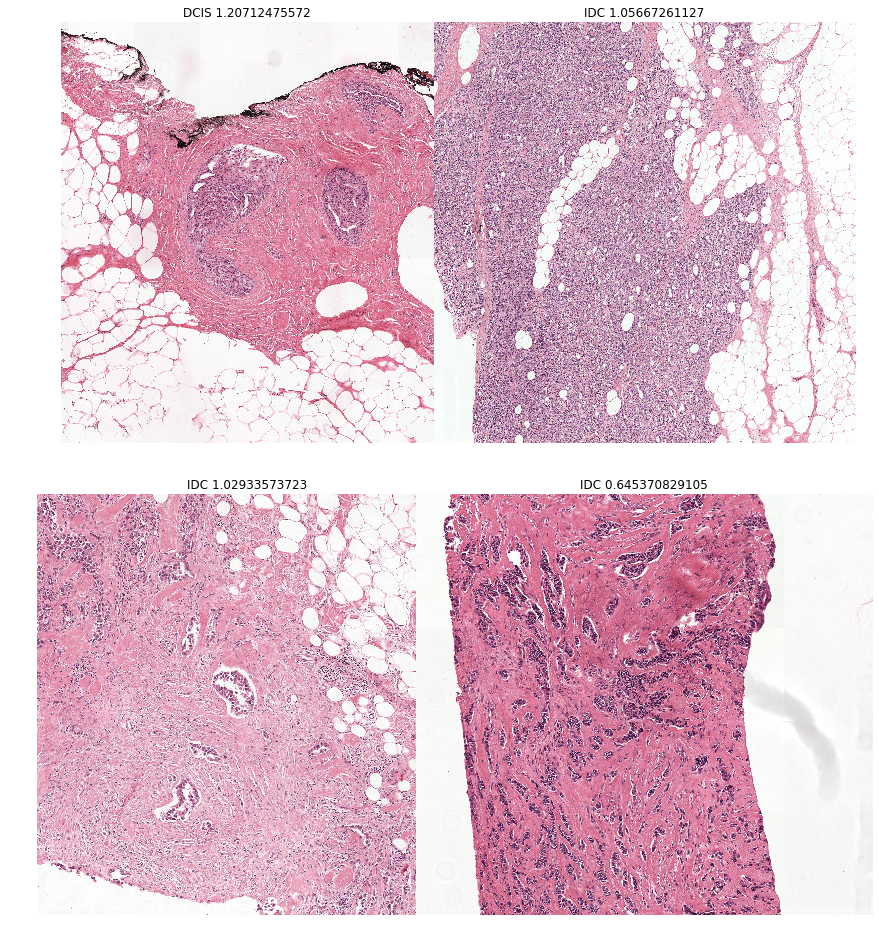

In [18]:
%matplotlib inline


import matplotlib.pyplot as plt
import util
from dataset import label_name


#For N by N plots
N = 2


for plot_number in range(0, len(wrong_images), N**2):
    
    if plot_number//N**2 >= 2: #Lets not plot too many
        break
        
    f, axarr = plt.subplots(N,N,figsize=(16,16))
    
    for i in range(min(N**2, len(wrong_images)-plot_number)):
        
        x = int(i%N)
        y = int(i/N)
        
        i = plot_number+i
        
        im = wrong_images[i].transpose(1,2,0)
        filename, loss = file_loss_tups[i]
        target = file_target[filename]
        
        
        axarr[y,x].imshow(im)
        axarr[y,x].set_title(label_name(target) + " " + str(loss))
        axarr[y,x].axis('off')
        
    plt.subplots_adjust(wspace = -0.2, hspace=0.12)
    plt.show()

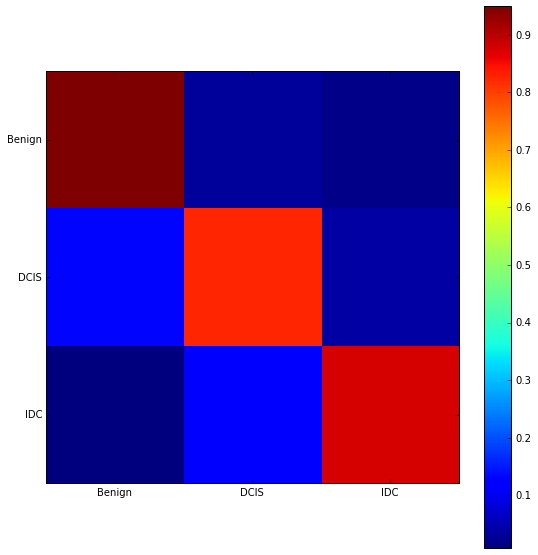

In [19]:
import sklearn.metrics
cm = sklearn.metrics.confusion_matrix(all_targets, all_binary_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

label_names = ['Benign', 'DCIS', 'IDC']

plt.figure(figsize=(8,8))
plt.imshow(cm_normalized, interpolation='nearest')
plt.xticks(np.arange(0,3), label_names)
plt.yticks(np.arange(0,3), label_names)
plt.tight_layout()
plt.colorbar()
plt.show()


In [20]:
# From https://gist.github.com/zachguo/10296432
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels]+[7]) # 7 is value length
    empty_cell = " " * columnwidth
    # Print header
    print "    " + empty_cell,
    for label in labels: 
        print "%{0}s".format(columnwidth) % label,
    print
    # Print rows
    for i, label1 in enumerate(labels):
        print "    %{0}s".format(columnwidth) % label1,
        for j in range(len(labels)): 
            cell = "%{0}.3f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print cell,
        print 
    
print_cm(cm_normalized, label_names)

             Benign    DCIS     IDC
     Benign   0.949   0.032   0.019
       DCIS   0.133   0.827   0.040
        IDC   0.009   0.112   0.879
